## Домашка 

### Задание 1 (8 баллов)
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на Recall@Precision меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.

### *Практически* полный перенос кода из лекции

In [3]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [4]:
import keras
print(keras.__version__)

3.8.0


In [5]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
data = pd.read_csv(r'./data/lenta_40k.csv.zip')

In [7]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [8]:
from razdel import tokenize

In [9]:
data["text"][0]

'Россия должна сотрудничать с Всемирным антидопинговым агентством (WADA), чтобы ее легкоатлеты смогли выступить на Олимпийских играх 2016 года в Рио-де-Жанейро. Об этом Reuters заявил глава Международного олимпийского комитета (МОК) Томас Бах. «Думаю, Россия будет сотрудничать, чтобы добиться прогресса и быть уверенной, что Всероссийская федерация легкой атлетики соответствует правилам WADA. Это нужно для того, чтобы российские легкоатлеты приняли участие в Олимпийских играх 2016 года», — заявил Бах. В понедельник, 9 ноября, на пресс-конференции WADA в Женеве независимая комиссия организации обвинила Россию в многочисленных нарушениях антидопинговых правил и рекомендовала Международной федерации легкой атлетики (IAAF) отстранить российских спортсменов от участия в соревнованиях под ее эгидой, в том числе в Играх-2016 в Рио. Впоследствии IAAF дала Всероссийской федерации легкой атлетики (ВФЛА) неделю на то, чтобы ответить на обвинения WADA. Пресс-секретарь президента России Владимира Пу

In [10]:
##  Препроц поменял тк так должно быть получше по идее
def preprocess(text):
    tokens = tokenize(text)
    tokens = [token.text.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return list(tokens)

In [11]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [12]:
len(vocab)

349591

In [13]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [14]:
len(filtered_vocab)

24956

In [15]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [16]:
id2word = {i:word for word, i in word2id.items()}

In [17]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [18]:
MAX_LEN = max(len(x) for x in X)

In [19]:
MEAN_LEN = np.median([len(x) for x in X])

In [20]:
MAX_LEN, int(MEAN_LEN)

(1733, 173)

In [21]:
MAX_LEN = int(MEAN_LEN + 30)

In [22]:
MAX_LEN, int(MEAN_LEN)

(203, 173)

In [23]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [24]:
X.shape

(44356, 203)

In [25]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [26]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [27]:
len(label2id)

19

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [29]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла 
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=5, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [28]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs, )

convs = []

for ks in[2,6,10,14,18]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=64, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=5, filters=128, strides=1, activation='relu')(conv1)
    pool = keras.layers.AveragePooling1D(pool_size=5)(conv2)
    drop = keras.layers.Dropout(0.7)(pool)
    convs.append(drop)

concat = keras.layers.concatenate(convs, axis=2)

conv_global1 = keras.layers.Conv1D(kernel_size=7, filters=32, strides=1)(concat)
global_drop = keras.layers.Dropout(0.5)(conv_global1)
conv_global2 = keras.layers.Conv1D(kernel_size=3, filters=128, strides=1)(global_drop)

flatten = keras.layers.Flatten()(conv_global2)

dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 203)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 203, 200)  │  4,991,400 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 203, 64)   │     25,664 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 203, 64)   │     76,864 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 203, 64)   │    128,064 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 203, 64)   │    179,264 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 203, 64)   │    230,464 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 199, 128)  │     41,088 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 199, 128)  │     41,088 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 199, 128)  │     41,088 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 199, 128)  │     41,088 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 199, 128)  │     41,088 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d   │ (None, 39, 128)   │          0 │ conv1d_1[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_1 │ (None, 39, 128)   │          0 │ conv1d_3[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_2 │ (None, 39, 128)   │          0 │ conv1d_5[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_3 │ (None, 39, 128)   │          0 │ conv1d_7[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_4 │ (None, 39, 128)   │          0 │ conv1d_9[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 39, 128)   │          0 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 39, 128)   │          0 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 39, 128)   │          0 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 39, 128)   │          0 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,192,387 (23.62 MB)

 Trainable params: 6,192,387 (23.62 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=15,
         callbacks=[checkpoint, early_stop])

/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/keras/src/backend/torch/nn.py:466: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  outputs = tnn.conv1d(


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - loss: 0.1876 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00180, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 557ms/step - loss: 0.1872 - rec@prec: 0.0000e+00 - val_loss: 0.1660 - val_rec@prec: 0.0018
Epoch 2/15
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - loss: 0.1613 - rec@prec: 8.0181e-04
Epoch 2: val_rec@prec improved from 0.00180 to 0.10956, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 557ms/step - loss: 0.1608 - rec@prec: 0.0013 - val_loss: 0.1351 - val_rec@prec: 0.1096
Epoch 3/15
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - loss: 0.1199 - rec@prec: 0.2285
Epoch 3: val_rec@prec improved from 0.10956 to 0.47295, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 556ms/step - loss: 0.1192 - rec@prec: 0.2368 - val_loss: 0.0994 - val_rec@prec: 0.4729
Epoch 4/15
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - loss: 0.0835 - rec@prec: 0.6009
Epoch 4: val_rec@prec impr

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


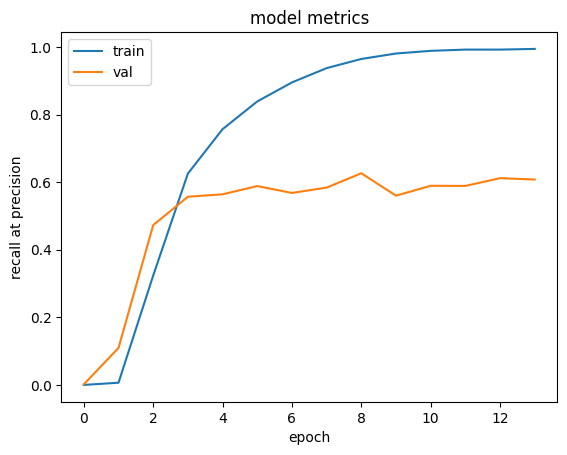

In [32]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Задание 2 (2 балла)
Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности с помощью CNN, а затем обратное увеличение длины последовательности до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями. 
Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже. 

Для повышения размерности используйте keras.layers.UpSampling1D
Полученная модель должна давать ненулевое качество на той же самой задаче классификации текстов.

In [34]:
class UNet:
    inputs = keras.layers.Input(shape=(MAX_LEN,))
    embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs, )

    # Даунсамплинг
    down_conv1   = keras.layers.Conv1D  (kernel_size=4, filters=16 , strides=1)(embeddings)
    down_dropout1 = keras.layers.Dropout(0.3)(down_conv1)

    down_conv2   = keras.layers.Conv1D  (kernel_size=4, filters=32 , strides=1)(down_dropout1)
    down_dropout2 = keras.layers.Dropout(0.3)(down_conv2)

    # Дно
    down_conv3   = keras.layers.Conv1D  (kernel_size=4, filters=64 , strides=1)(down_dropout2)
    down_dropout3 = keras.layers.Dropout(0.3)(down_conv3)

    # Апсамплинг
    up1      = keras.layers.UpSampling1D()(down_dropout3)
    up_conv2 = keras.layers.Conv1D  (kernel_size=4, filters=32 , strides=1)(up1)

    up2        = keras.layers.UpSampling1D()(up_conv2)
    down_conv1 = keras.layers.Conv1D  (kernel_size=4, filters=16 , strides=1)(up2)

    flatten = keras.layers.Flatten()(down_conv1)

    dense = keras.layers.Dense(50, activation='relu')(flatten)
    outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [35]:
UNet.model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 203)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 203, 200)       │     4,991,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 200, 16)        │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 197, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 197, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 394, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 391, 32)        │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 782, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 779, 16)        │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12464)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │       623,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,636,707 (21.50 MB)

 Trainable params: 5,636,707 (21.50 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
UNet.model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=15,
         callbacks=[checkpoint, early_stop])

Epoch 1/15


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1866 - rec@prec: 4.4112e-05
Epoch 1: val_rec@prec improved from -inf to 0.04734, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.1861 - rec@prec: 4.9417e-05 - val_loss: 0.1525 - val_rec@prec: 0.0473
Epoch 2/15
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1408 - rec@prec: 0.0618
Epoch 2: val_rec@prec improved from 0.04734 to 0.28629, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.1399 - rec@prec: 0.0673 - val_loss: 0.1149 - val_rec@prec: 0.2863
Epoch 3/15
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0964 - rec@prec: 0.4888
Epoch 3: val_rec@prec improved from 0.28629 to 0.62263, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0958 - rec@prec: 0.4949 - val_loss: 0.0842 - val_rec@prec: 0.6226
Epoch 4/15
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0650 - rec@prec: 0.7350
Epoch 4: val_rec@prec did not improve from 0

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


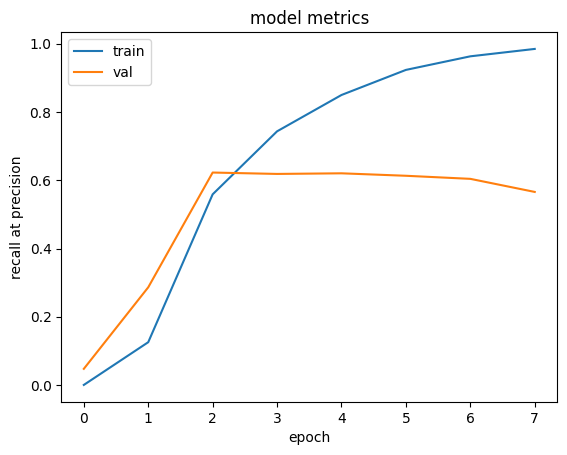

In [37]:
print(UNet.model.history.history.keys())
# summarize history for accuracy
plt.plot(UNet.model.history.history['rec@prec'])
plt.plot(UNet.model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()